In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

um = 1
nm = 0.001
λ  = 1*um


In [3]:
from funciones import GS_phase_retrieval,get_modes_power_scalar

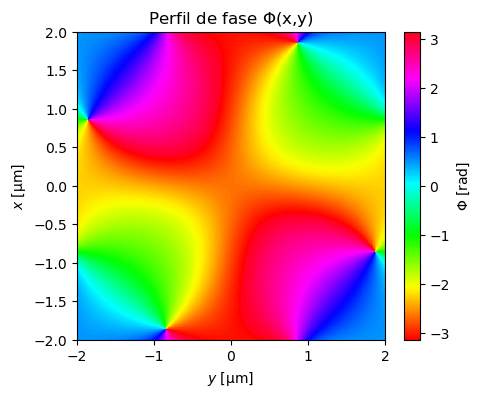

In [3]:
Λu, Λv = 1,1
Λx, Λy = 4.0, 4.0
Nx,Ny = 512,512
dx,dy = Λx/Nx , Λy/Ny
source_amplitude = jnp.ones((Ny, Nx))
incident_power = 0.5 * Λx*Λy
target_power = 0.5 * 9 * Λx*Λy


def input_fun(x,y):
    return x*0 + 1.0


def target_fun(fx,fy):
    nn_, mm_ = fx* Λx, fy* Λy
    return ((jnp.abs(nn_) < 2)  & (jnp.abs(mm_) < 2) ).astype('complex64') /(target_power) * (incident_power)

retrieved_phase,error_list = GS_phase_retrieval(input_fun,target_fun, Λx, Λy, Nx, Ny,num_iter = 195)


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(retrieved_phase.reshape(Ny,Nx), origin = 'lower', cmap ='hsv', interpolation  = 'none', extent=[-Λx/um/2, Λx/um/2, -Λy/um/2, Λy/um/2], vmax = np.pi, vmin = -np.pi)
cb1 = fig.colorbar(im, orientation = 'vertical',fraction=0.045, label = '$\Phi$ [rad]')
ax.set_ylabel("$x$ [μm]")
ax.set_xlabel('$y$ [μm]')
ax.set_title(r"Perfil de fase $\Phi$(x,y)")
plt.show()

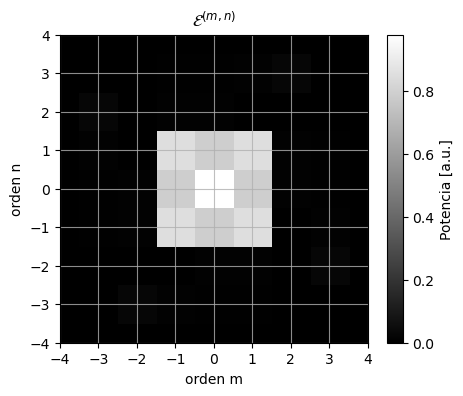

In [6]:
λ = 1*um
mm_, nn_, pow_mode = get_modes_power_scalar(jnp.exp(1j*retrieved_phase), λ, a1 = jnp.array([4.0, 0.0]), a2 = jnp.array([0.0, 4.0]), 
                           eps = 1,mu = 1)



fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
Nx_ = mm_[0,:]
Ny_ = nn_[:,0]
im = ax.imshow((jnp.abs(pow_mode)),aspect = 'equal', origin = 'lower', cmap ='gray', interpolation  = 'none', extent=[Nx_[0]-0.5, Nx_[-1] +0.5, Ny_[0] -0.5, Ny_[-1] + 0.5],  vmin = 0)
ax.set_title(r"$\mathcal{E}^{\left(m,n\right)}$")
ax.set_xlabel("orden m")
ax.set_ylabel("orden n")
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])

ticks = np.arange(-4, 5, 1)  # Creates an array from -4 to 4 inclusive with a step of 1.
ax.set_xticks(ticks)
ax.set_yticks(ticks)

plt.grid(alpha = 0.8)
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Potencia [a.u.]')
plt.show()


In [17]:
orders = pow_mode[(jnp.abs(nn_) < 2)  & (jnp.abs(mm_) < 2)]
non_uniform = jnp.abs((orders.max()- orders.min())/(orders.max()+ orders.min()))
non_uniform

Array(0.10599049, dtype=float64)

In [18]:
eff = jnp.abs(jnp.sum(orders) /jnp.sum(pow_mode))
eff

Array(0.9614825, dtype=float64)

In [19]:
np.save('grating_phase_square-GS_xy.npy', retrieved_phase)

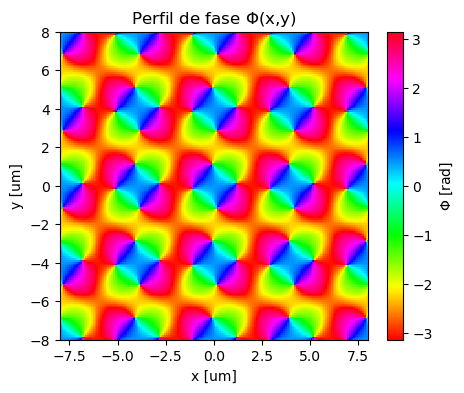

In [5]:
from scipy.interpolate import interpn

phase = np.load('grating_phase_square-GS_xy.npy')

a=4
Λx = a
Λy = a
Ny_old,Nx_old = phase.shape
x_old = jnp.linspace(0, Λx, Nx_old)
y_old = jnp.linspace(0, Λy, Ny_old)
Ny, Nx = 6326 //3,6326 //3
extent_x = 200
extent_y = 200
dx = extent_x/Nx
dy = extent_y/Ny
x = dx * (jnp.arange(Nx)-Nx//2)
y = dy * (jnp.arange(Ny)-Ny//2)
xx, yy = jnp.meshgrid(x, y)
oldpoints = (x_old,y_old)
newpoints = np.vstack([(xx%Λx).ravel(),(yy%Λy).ravel()]).T
phase_grating_interpolated = jnp.arctan2( interpn(oldpoints, np.sin(phase).T, newpoints, bounds_error=True, fill_value = 0, method = 'linear').reshape((Ny, Nx))   ,   interpn(oldpoints, np.cos(phase).T, newpoints, bounds_error=True, fill_value = None, method = 'linear').reshape((Ny, Nx))  )


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

im = ax.imshow(phase_grating_interpolated, origin = 'lower', cmap ='hsv', interpolation  = 'none', extent = [xx[0,0], xx[0,-1],yy[0,0], yy[-1,0]], vmax = np.pi, vmin = -np.pi)
cb1 = fig.colorbar(im, orientation = 'vertical',fraction=0.045, label = '$\Phi$ [rad]')

ax.set_title(r"Perfil de fase $\Phi$(x,y)")
ax.set_ylabel("y [um]")
ax.set_xlabel("x [um]")
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])

plt.show()


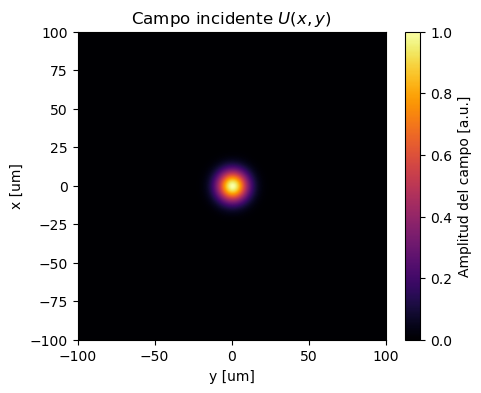

78.53981633974483

In [8]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

U_new = jnp.exp(-((xx**2 +  yy**2) / 10**2)) * jnp.exp(1j*phase_grating_interpolated)

im = ax.imshow(np.abs(U_new), cmap ='inferno', extent=[float(x[0]), float(x[-1])+dx, float(y[0]), float(y[-1])+dy])
ax.set_title("Campo incidente $U(x,y)$")
ax.set_ylabel("x [um]")
ax.set_xlabel('y [um]')


lim = np.array([-5,5])
#ax.set_xlim(lim)
#ax.set_ylim(lim)

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Amplitud del campo [a.u.]')
plt.show()


from scipy.integrate import simps
Iz = 0.5*np.real(np.multiply(U_new,np.conj(U_new)))
power00 = simps(simps(Iz, x), y)
power00

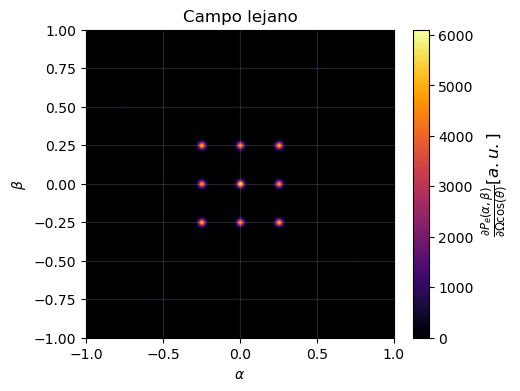

In [9]:
from funciones import get_farfield_radiant_intensity_percos_scalar

λ= 1.0
α, β, Intensity = get_farfield_radiant_intensity_percos_scalar(x, y, U_new, λ)


fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(1,1,1)  
ax.grid(alpha =0.2)
ax.set_title(r"Campo lejano")
ax.set_ylabel("$β$")
ax.set_xlabel('$α$')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

im = ax.imshow((Intensity), extent = [α[0],α[-1],β[0],β[-1]], origin = 'lower', cmap = 'inferno',vmax =  (Intensity.max()))
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label(r"$\frac{\partial P_e(α,β)}{\partial \Omega \cos(\theta)} [a.u.]$", size= 12)
plt.show()
